# Boostrapping error metrics for SAMPL5

What's here is copied from Niel's `Boot8` directory on Kirkwood. I am adding new plots to the code but not changing any of the underlying calculations.

In [387]:
import sys,re
import numpy as np
from scipy import stats
import matplotlib as mpl 
import matplotlib.pyplot as plt
# Wrangle the data
import pandas as pd
# Nice figures
import seaborn as sns
# Access data
import os
# Save the results of bootstrapping
import pickle

# mpl.use('agg')
%matplotlib inline
# Pretty graphs for Jane
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',  
       r'\sisetup{detect-all}',   
       r'\usepackage{helvet}',    
       r'\usepackage{sansmath}',  
       r'\sansmath',
       r'\renewcommand{\familydefault}{\sfdefault}',
       r'\usepackage[T1]{fontenc}'
]

## Function definitions for setting the error metrics, reading the data, performing bootstrap analysis, and plotting the results.

In [69]:
def geterrormetrics(x, y, Nm):
    """
    Returns an array MTmp that stores the output of the error metrics on data given in (x, y).
    Written by Niel.
    """
    MTmp = np.zeros([Nm], np.float64)
    # Slope, Intercept, R
    Slp, MTmp[1], MTmp[2], pval, stderr = stats.linregress(x,y)
    MTmp[0] = np.abs(1-Slp)
    # R^2
    MTmp[3] = MTmp[2]**2
    # RMSE
    MTmp[4] = np.sqrt(np.mean(((y - x)**2)))
    # MSE
    MTmp[5] = np.mean((y - x))
    # MUE
    MTmp[6] = np.mean(np.absolute(y - x))
    # Tau
    MTmp[7], prob = stats.kendalltau(x,y)
    return (MTmp)

In [70]:
### BootStrapping Definition
def bootstrap(x, xsem, y, ysem, Nm, BootCyc, OAHOnly, OAMeOnly, CalcPairDiffs, CorrectOA, CorrectCB, WithUncert, WithRep):
    """
    Performs bootstrap error anaysis on data (x, y) and errors (xsem, ysem) for a number
    of bootstrapping cycles given by BootCyc. The remaining parameters specify subsets of calculations
    that can be performed which are determined in the function `compute_bootstrap`.
    Returns an array of values, uncertainties, and MBoot which holds an array of all values for
    the error metrics for all bootstrapping cycles. 
    Written by Niel.
    """

    MBoot = np.zeros([Nm,BootCyc], np.float64)
    MVals = np.zeros([Nm], np.float64)
    MSEMs = np.zeros([Nm], np.float64)
    xtmp = np.zeros([len(x)], np.float64)
    ytmp = np.zeros([len(x)], np.float64)
    yfit = np.zeros([len(x)], np.float64)

    for b in range(BootCyc):
        for i in range(len(x)):

          # Sample with/without replacement?
          if WithRep:
            j = np.random.randint(len(x))
          else:
            j = i

          # Sampling Statistical Uncertainty
          if not WithUncert or xsem[j] == 0.0:
            xtmp[i] = x[j]
          else:
            xtmp[i] = np.random.normal(x[j],xsem[j])
          if not WithUncert or ysem[j] == 0.0:
            ytmp[i] = y[j]
          else:
            ytmp[i] = np.random.normal(y[j],ysem[j])

          MBoot[0:Nm,b] = geterrormetrics(xtmp, ytmp, Nm)

    for m in range(Nm):
        MVals[m]=np.mean(MBoot[m])
        MSEMs[m]=np.std(MBoot[m])

    return (MVals,MSEMs,MBoot)

In [71]:
def compute_bootstrap(args):
    """
    Read in data from disk given by `args`, convert to common units if necessary, 
    set calculation subsets, and call `bootstrap`.
    Returns the number of calculations (i.e., the number of data files), the name of those files,
    the raw (i.e., reported by submission) value of the error metrics, all bootstrapped values of the
    error metrics, and all bootstrapped mean values.
    Written by Niel.
    """

    OAHOnly = False
    OAMeOnly = False
    CalcPairDiffs = False
    CorrectOA = False
    CorrectCB = False
    WithUncert = True 
    WithRep = True  

    ### Arguments: <Flags> <ExpType> <ExperimentFile> <CalculationFile1> [<CalculationFile2> ...]
    ### Note, files should have the same number of data points
    calcfiles=[]
    for arg in args:
      if arg == 'OAHOnly':
        OAHOnly = True
      if arg == 'OAMeOnly':
        OAMeOnly = True
      if arg == 'CalcPairDiffs':
        CalcPairDiffs = True
      if arg == 'CorrectOA':
        CorrectOA = True
      if arg == 'CorrectCB':
        CorrectCB = True
      if re.search(r'^(ka|dg|dh)$', arg):
        exptype = arg
      if re.search(r'\.txt$', arg):
        if re.search(r'Exp', arg):
          expfile = arg
        else:
          calcfiles.append(arg)


    ### Settings
    R = 0.0019872036
    T = 298.0
    BootCyc = 100000
    MNames = ('Slope', 'Interc', 'R', 'R^2', 'RMSE', 'MSE', 'MUE', 'TAU')
    Nm = len(MNames)
    
    ### Load experimental file and place data in array
    print(expfile)
    with open(expfile, 'r') as expraw:
      explines = expraw.readlines()
    exp = []
    for line in explines:
      if not re.match(r'^\s*$', line):
        exp.append(line.rstrip().replace('\t', ' '))

    ### If "Only" flag, just do first six, or last six
    if OAHOnly:
      exp = exp[0:6]
    if OAMeOnly:
      exp = exp[6:12]
    if OAHOnly and OAMeOnly:
      print("OAHOnly=True and OAMeOnly=True! Not compatible")
      exit()
    N = len(exp)	# Number of data points
    Np = (N-1)*N/2  # Number of data pairs

    ### Are these binding constants or free energy (or enthalpy)? Convert.
    emean = np.zeros([N], np.float64)
    esem = np.zeros([N], np.float64)
    for i in range(len(exp)):
      cols = np.asarray(exp[i].split(), dtype=np.float64)
      if exptype == 'ka':       ### Assume binding constant. This could go wrong for very positive enthalpy
        dG = -R*T*np.log(cols)
        emean[i] = np.mean(dG)
        esem[i] = np.std(dG, ddof=1)/np.sqrt(len(dG))
      elif exptype == 'dg':
        emean[i] = cols[0]
        esem[i] = cols[1]
      elif exptype == 'dh': 
        emean[i] = np.mean(cols)/1000
        esem[i] = np.std(cols, ddof=1)/np.sqrt(len(cols))/1000
      else:
        print(exptype, "... is not a valid experimental type")

    ### Calculate Experimental Pairwise Differences
    if CalcPairDiffs:
      h = 0
      epmean = np.zeros([Np], np.float64)
      epsem = np.zeros([Np], np.float64)
      for i in range(len(exp)):
        for j in range(i+1, len(exp)):
          epmean[h] = emean[i] - emean[j]
          epsem[h] = np.sqrt( esem[i]**2 + esem[j]**2 )
          h += 1

    ### Read in Calculated data.  
    ### I should add a check to make sure number of data points is the same as experiment
    Nc = len(calcfiles)
    cmean = np.zeros([Nc,N], np.float64)
    csem = np.zeros([Nc,N], np.float64)
    if CalcPairDiffs:
      cdmean = np.zeros([Nc,Nd], np.float64)
      cdsem = np.zeros([Nc,Nd], np.float64)

    RawMs = np.zeros([Nc,Nm], np.float64)
    AllMBoot = np.zeros([Nc,Nm,BootCyc], np.float64)
    AllMVals = np.zeros([Nc,Nm], np.float64)
    AllMSEMs = np.zeros([Nc,Nm], np.float64)

    ### Print Metrics Column Headings
    #print "%30s " % ("Submission"),
    #for Name in MNames:
    #  print "%6s " % (Name),
    #print ""

    nc = 0
    for calcfile in calcfiles:
      calc = np.loadtxt(calcfile, np.float64)
      if OAHOnly:
        calc = calc[0:6]
      if OAMeOnly:
        calc = calc[6:12]
      for i in range(len(calc)):
        if np.isscalar(calc[i]) == True:      ### If scalar instead of array; ie, no SEM given.
          cmean[nc,i] = np.mean(calc[i])
          csem[nc,i] = 0.0
        else:                                 ### Assume Mean and SEM given
          cmean[nc,i] = calc[i,0]
          csem[nc,i] = calc[i,1]
        #print emean[i],esem[i],tmpcmean[i],tmpcsem[i]


      ### Correct data set with MSE
      if CorrectOA:
        cmean[nc,0:6] = cmean[nc,0:6] - (np.mean(cmean[nc,0:6]) - np.mean(emean[0:6]))
        if len(calc) == 12:
          cmean[nc,6:12] = cmean[nc,6:12]- (np.mean(cmean[nc,6:12]) - np.mean(emean[6:12]))
      if CorrectCB:
        cmean[nc,0:10] = cmean[nc,0:10] - (np.mean(cmean[nc,0:10]) - np.mean(emean[0:10]))

      if CalcPairDiffs:
        h = 0
        for i in range(len(calc)):
          for j in range(i+1, len(calc)):
            cpmean[nc,h] = cmean[nc,i] - cmean[nc,j]
            cpsem[nc,h] = np.sqrt( csem[nc,i]**2 + csem[nc,j]**2 )
            #print cpmean[nc,h]#,cdsem[nc,h]
            h += 1

      RawMs[nc] = geterrormetrics(emean, cmean[nc], Nm)
      AllMVals[nc],AllMSEMs[nc],AllMBoot[nc] = bootstrap(emean, esem, cmean[nc], csem[nc], 
                                                         Nm, BootCyc, OAHOnly, OAMeOnly, 
                                                         CalcPairDiffs, CorrectOA, CorrectCB, 
                                                         WithUncert, WithRep)
      #print "%30s " % (calcfile),
      #for m in range(Nm):
      #  print "%6.2f " % (RawMs[nc,m]),
      #print ""

      nc += 1
    
    CalcNames=[]
    for name in calcfiles:
      cols = name.split('.')
      CalcNames.append(cols[0])

    
    return(RawMs, AllMBoot, AllMVals, CalcNames, Nc)

In [72]:
def plot_summary(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix):
    """
    Make a vertical violin plot of the bootstrapped error metrics and save to disk.
    Points are overlaid to represent the mean of each submission and lines are drawn
    to shown the bootstrapped mean. For each error metric, a single graph is drawn:
    RMSE, slope, R squared, and Kendall tau. There is manual tweaking of names, labels,
    and colors.
    There is an implicit plt.show() at the end of the function.
    """
    
    # Set the graph labels to different for absolute and relative calculations.
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-Slope)_c", "$R^{2}$_c", "Tau_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    
    for i in calculation_index:
        
        tmp = np.argsort(RawMs[0:Nc,i])
        Order = [j for j in tmp]
        print('Calculation = {}, best method index = {}, best method name = {}'.format(i, 
                                                                                       np.argsort(RawMs[0:Nc,i])[0], 
                                                                                       CalcNames[np.argsort(RawMs[0:Nc,i])[0]]))
 
        # For R squared and Tau reverse the ordering so the graphs always present best to worst case (left to right or top to bottom).
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c' or calculation_name[calculation_index.index(i)] == 'Tau_c':  
            Order = np.argsort(RawMs[0:Nc,i])[::-1]
    
        # Cleanup submission names grabbed from the filenames.        
        CalcNames=['TI/BAR' if i == 'TIxBar' else i for i in CalcNames]
        CalcNames=['MovTyp-1*' if i == 'MovTyp-1' else i for i in CalcNames] 
        CalcNames=['MovTyp-2*' if i == 'MovTyp-2' else i for i in CalcNames] 
        CalcNames=['Null1*' if i == 'Null1' else i for i in CalcNames] 
        CalcNames=['DFT-neutral*' if i == 'DFT-neutral' else i for i in CalcNames] 
        CalcNames=['DFT-charged*' if i == 'DFT-charged' else i for i in CalcNames] 
        CalcNames=['CCSD(T)-neutral*' if i == 'CCSD(T)-neutral' else i for i in CalcNames]
    
        # Exclude Null1 model from Tau calculation and plotting.
        if i == 7 and absolute == True:
            element_to_remove = np.where([CalcNames[i] == 'Null1*' for i in Order])[0][0]
            print('Removing element {} from Order, method {}, from Tau calculation.'.format(element_to_remove, 
                                                                                            CalcNames[element_to_remove]))
            Order_without_null1 = np.delete(Order, element_to_remove)
            Order = np.copy(Order_without_null1)
        
        # Wrangle the data into a `DataFrame` so we can do categorical plotting with seaborn.
        # The bootstrapped error distributions.
        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))
        # The 'raw' (submitted) values for the error metrics.
        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]
        # The bootstrapped error means.
        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]
        # Set axes labels for the submissions.
        labels = [CalcNames[n] for n in Order]
        # Blue for everything except red for null models. Jane's favorite blue.
        palette = ['#4169e1' if i != 'Null1*' and i != 'Null2' else '#fa8072' for i in labels]
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})

        fig, ax = plt.subplots(1, figsize=(18,12), dpi=300)        
        g = sns.violinplot(x = 'Method', y = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0)
        # Nudge the ticks for Jane.
        g.set_xticks([i + 0.25 for i in range(len(Order))])
        for n in Order:
            # Plot the 'raw' (submitted) values for the error metrics as white circles with a black border
            ax.scatter(x = np.where(Order == n)[0], y = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, 
                       marker = 'o', color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
            # Plot the bootstrapped mean values as a line.
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(Order)) + 0.01, 
                       xmax = np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01, 
                       linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            ax.axhline(y = AllMVals[n, i], xmin = (np.where(Order == n)[0] / len(Order)) + 0.01, 
                       xmax = np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01, 
                       linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
                        
        plt.xticks(rotation=45, ha='right')
        plt.ylabel(calculation_name[calculation_index.index(i)])
        plt.xlabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            ax.set_ylim([-0.05, 1])
        # Let's limit for Tau, too:
        if calculation_name[calculation_index.index(i)] == 'Tau' or calculation_name[calculation_index.index(i)] == 'Tau_c':
            ax.set_ylim([-1.0, 1.0])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)' or calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)_c':
            ax.set_ylim([-0.5, 6])
        if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
            ax.set_ylim([-0.5, np.max(df2['RawMs'])+0.5*np.max(df2['RawMs'])])

        # Because RMSE has units and we don't want them in the title.
        if calculation_name[calculation_index.index(i)] != 'RMSE (kcal/mol)' and calculation_name[calculation_index.index(i)] != 'RMSE_c (kcal/mol)':
            plt.title(prefix + ', ' + calculation_name[calculation_index.index(i)])
        elif absolute:
            plt.title(prefix + ', ' + 'RMSE')
        elif relative:
            plt.title(prefix + ', ' + 'RMSE_c')

In [73]:
def plot_summary_horizontal(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix, filename=None):
    """
    Make a horizontal violin plot of the bootstrapped error metrics and save to disk.
    Points are overlaid to represent the mean of each submission and lines are drawn
    to shown the bootstrapped mean. For each error metric, a single graph is drawn:
    RMSE, slope, R squared, and Kendall tau. There is manual tweaking of names, labels,
    and colors.
    The figures are saved given by the parameter `filename`.
    """

    # Set the graph labels to different for absolute and relative calculations.
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-Slope)_c", "$R^{2}$_c", "Tau_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    

    for i in calculation_index:
        tmp = np.argsort(RawMs[0:Nc,i])
        Order = [j for j in tmp]
        print('Calculation = {}, best method index = {}, best method name = {}'.format(i, 
                                                                                       np.argsort(RawMs[0:Nc,i])[0], 
                                                                                       CalcNames[np.argsort(RawMs[0:Nc,i])[0]]))
        # For R squared and Tau reverse the ordering so the graphs always present best to worst case (left to right or top to bottom).
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c' or calculation_name[calculation_index.index(i)] == 'Tau_c':  
            Order = np.argsort(RawMs[0:Nc,i])[::-1]
            
        # Cleanup submission names grabbed from the filenames.        
        CalcNames=['TI/BAR' if i == 'TIxBar' else i for i in CalcNames]
        CalcNames=['MovTyp-1*' if i == 'MovTyp-1' else i for i in CalcNames] 
        CalcNames=['MovTyp-2*' if i == 'MovTyp-2' else i for i in CalcNames] 
        CalcNames=['Null1*' if i == 'Null1' else i for i in CalcNames] 
        CalcNames=['DFT-neutral*' if i == 'DFT-neutral' else i for i in CalcNames] 
        CalcNames=['DFT-charged*' if i == 'DFT-charged' else i for i in CalcNames] 
        CalcNames=['CCSD(T)-neutral*' if i == 'CCSD(T)-neutral' else i for i in CalcNames]
        
        # Exclude Null1 model from Tau calculation and plotting.
        if i == 7 and absolute == True:
            # Exclude Null1 model from Tau calculation and plotting.
            element_to_remove = np.where([CalcNames[i] == 'Null1*' for i in Order])[0][0]
            print('Removing element {} from Order, method {}, from Tau calculation.'.format(element_to_remove, 
                                                                                            CalcNames[element_to_remove]))
            Order_without_null1 = np.delete(Order, element_to_remove)
            Order = np.copy(Order_without_null1)

        # Wrangle the data into a `DataFrame` so we can do categorical plotting with seaborn.
        # The bootstrapped error distributions.
        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))
        # The 'raw' (submitted) values for the error metrics.
        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]
        # The bootstrapped error means.
        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]
        # Set axes labels for the submissions.
        labels = [CalcNames[n] for n in Order]
        # Blue for everything except red for null models. Jane's favorite blue.
        palette = ['#4169e1' if i != 'Null1*' and i != 'Null2' else '#fa8072' for i in labels]
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 2.5})

        fig, ax = plt.subplots(1, figsize=(18,12), dpi=300)
        g = sns.violinplot(y = 'Method', x = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0, 
                           orientation='h', split=True)

        for n in Order:
            # Plot the 'raw' (submitted) values for the error metrics as white circles with a black border
            ax.scatter(y = np.where(Order == n)[0], x = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', 
                       color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
            # Plot the bootstrapped mean values as a line.
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
                        
        plt.xlabel(calculation_name[calculation_index.index(i)])
        plt.ylabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            ax.set_xlim([0, 1])
        # Let's limit for Tau, too:
        if calculation_name[calculation_index.index(i)] == 'Tau' or calculation_name[calculation_index.index(i)] == 'Tau_c':
            ax.set_xlim([-1.0, 1.0])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)' or calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)_c':
            ax.set_xlim([0, 6])
        if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
            ax.set_xlim([-0.5, np.max(df2['RawMs'])+0.5*np.max(df2['RawMs'])])

        # Because RMSE has units and we don't want them in the title.
        if calculation_name[calculation_index.index(i)] != 'RMSE (kcal/mol)' and calculation_name[calculation_index.index(i)] != 'RMSE_c (kcal/mol)':
            plt.title(prefix + ', ' + calculation_name[calculation_index.index(i)])
        elif absolute:
            plt.title(prefix + ', ' + 'RMSE')
        elif relative:
            plt.title(prefix + ', ' + 'RMSE_c')
        if filename:
            if i == 0:
                label = 'slope'
            if i == 4:
                label = 'rmse'
            if i == 3:
                label = 'r-squared'
            if i == 7:
                label = 'tau'
            plt.savefig(filename + '-' + str(label) + '.png', dpi=300)

In [396]:
def plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix, filename=None):
    """
    Make a horizontal violin plot of the bootstrapped error metrics and save to disk.
    Points are overlaid to represent the mean of each submission and lines are drawn
    to shown the bootstrapped mean. For each error metric, a single graph is drawn:
    RMSE, slope, R squared, and Kendall tau. There is manual tweaking of names, labels,
    and colors.
    In this version, the aspect ratio is changed to make the plots a bit more narrow and long.
    Also, bigger font size for Jane.
    The figures are saved given by the parameter `filename`.
    """

    # Set the graph labels to different for absolute and relative calculations.
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-Slope)_c", "$R^{2}$_c", "Tau_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    

    for i in calculation_index:
        tmp = np.argsort(RawMs[0:Nc,i])
        Order = [j for j in tmp]
        print('Calculation = {}, best method index = {}, best method name = {}'.format(i, 
                                                                                       np.argsort(RawMs[0:Nc,i])[0], 
                                                                                       CalcNames[np.argsort(RawMs[0:Nc,i])[0]]))
        
        # Hack the order so that if two reported means are the same to the first two decimal places, order by 
        # the distribution mean.

        # Created rounded values for these arrays, order doesn't matter -- round all values
        round_RawMs = np.around(RawMs[:,i], 1)
        round_AllMVals = np.around(AllMVals[:,i], 1)
        # print(RawMs[:,i])
        # print(AllMVals[:,i])
        # print (round_RawMs)
        # print(round_AllMVals)
        # Data frame for boostrapped values, raw values, and original order
        rounds = pd.DataFrame()
        rounds['b'] = round_AllMVals
        rounds['r'] = round_RawMs
        rounds['o'] = range(len(round_AllMVals))
        rounds['m'] = [CalcNames[i] for i in range(len(AllMVals))]
        # Reorder array based on raw value first, then bootstrapped
        ordered = rounds.sort_values(['r', 'b'], inplace=False)
        # Grab the values of the third column, which was original order, based on 
        # values of first two columns
        Order = ordered['o'].as_matrix()
        print(Order)
        
        # For R squared and Tau reverse the ordering so the graphs always present best to worst case (left to right or top to bottom).
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c' or calculation_name[calculation_index.index(i)] == 'Tau_c':  
            # Order = np.argsort(RawMs[0:Nc,i])[::-1]
            Order = ordered['o'].as_matrix()[::-1]
            
        # Cleanup submission names grabbed from the filenames.        
        CalcNames=['TI/BAR' if i == 'TIxBar' else i for i in CalcNames]
        CalcNames=['MovTyp-1*' if i == 'MovTyp-1' else i for i in CalcNames] 
        CalcNames=['MovTyp-2*' if i == 'MovTyp-2' else i for i in CalcNames] 
        CalcNames=['Null1*' if i == 'Null1' else i for i in CalcNames] 
        CalcNames=['DFT-neutral*' if i == 'DFT-neutral' else i for i in CalcNames] 
        CalcNames=['DFT-charged*' if i == 'DFT-charged' else i for i in CalcNames] 
        CalcNames=['CCSD(T)-neutral*' if i == 'CCSD(T)-neutral' else i for i in CalcNames]
        
        # Exclude Null1 model from Tau calculation and plotting.
        if i == 7 and absolute == True:
            # Exclude Null1 model from Tau calculation and plotting.
            element_to_remove = np.where([CalcNames[i] == 'Null1*' for i in Order])[0][0]
            print('Removing element {} from Order, method {}, from Tau calculation.'.format(element_to_remove, 
                                                                                            CalcNames[element_to_remove]))
            Order_without_null1 = np.delete(Order, element_to_remove)
            Order = np.copy(Order_without_null1)
        

        # Wrangle the data into a `DataFrame` so we can do categorical plotting with seaborn.
        # The bootstrapped error distributions.
        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))
        # The 'raw' (submitted) values for the error metrics.
        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]
        # The bootstrapped error means.
        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]
        # Set axes labels for the submissions.
        labels = [CalcNames[n] for n in Order]
        # Blue for everything except red for null models. Jane's favorite blue.
        palette = ['#4169e1' if i != 'Null1*' and i != 'Null2' else '#fa8072' for i in labels]
        sns.set_style("whitegrid", rc={'legend.frameon': False})
        sns.set_context("paper", font_scale=5, rc={"lines.linewidth": 2.5, 'legend.frameon': False})
        sns.despine(left=True, bottom=True, right=True, top=True)


        
        fig, ax = plt.subplots(1, figsize=(12,18), dpi=300)
        g = sns.violinplot(y = 'Method', x = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0, 
                           orientation='h', split=True)

        for n in Order:
            # Plot the 'raw' (submitted) values for the error metrics as white circles with a black border
            ax.scatter(y = np.where(Order == n)[0], x = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', 
                       color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
            # Plot the bootstrapped mean values as a line.
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            ax.axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
                        
        plt.xlabel(calculation_name[calculation_index.index(i)])
        plt.ylabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            ax.set_xlim([0, 1])
        # Let's limit for Tau, too:
        if calculation_name[calculation_index.index(i)] == 'Tau' or calculation_name[calculation_index.index(i)] == 'Tau_c':
            ax.set_xlim([-1.0, 1.0])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)' or calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)_c':
            ax.set_xlim([0, 6])
        if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
            ax.set_xlim([-0.5, np.max(df2['RawMs'])+0.5*np.max(df2['RawMs'])])

        # Because RMSE has units and we don't want them in the title.
        if calculation_name[calculation_index.index(i)] != 'RMSE (kcal/mol)' and calculation_name[calculation_index.index(i)] != 'RMSE_c (kcal/mol)':
            plt.title(prefix + ', ' + calculation_name[calculation_index.index(i)])
        elif absolute:
            plt.title(prefix + ', ' + 'RMSE')
        elif relative:
            plt.title(prefix + ', ' + 'RMSE\\_c')
        # Make R**2 font the same as the rest.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$':
            plt.title(prefix + ', ' + '$\\text{R}^{\\text{2}}$')
            plt.xlabel('$\\text{R}^{\\text{2}}$')

        # Because LaTeX rendering, we have to escape these underscores...
        if relative: 
            if i == 0:
                latex_label = 'Abs(1-Slope)\\_c'
                latex_title = 'Abs(1-Slope)\\_c'
            if i == 4:
                latex_label = 'RMSE\\_c (kcal/mol)'
                latex_title = 'RMSE\\_c'
            if i == 3:
                latex_label = '$\\text{R}^{\\text{2}}$\\_c'
                latex_title = '$\\text{R}^{\\text{2}}$\\_c'
            if i == 7:
                latex_label = 'Tau\\_c'
                latex_title = 'Tau\\_c'
            plt.xlabel(latex_label)
            plt.title(prefix + ', ' + latex_title)

        if filename:
            if i == 0:
                label = 'slope'
            if i == 4:
                label = 'rmse'
            if i == 3:
                label = 'r-squared'
            if i == 7:
                label = 'tau'
            plt.tight_layout()
            plt.savefig(filename + '-' + str(label) + '-narrow.png', dpi=300)

In [425]:
def plot_summary_horizontal_narrow_four_in_one(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute, relative, prefix, filename=None):
    """
    Make a horizontal violin plot of the bootstrapped error metrics and save to disk.
    Points are overlaid to represent the mean of each submission and lines are drawn
    to shown the bootstrapped mean. For each error metric, a single graph is drawn:
    RMSE, slope, R squared, and Kendall tau. There is manual tweaking of names, labels,
    and colors.
    In this version, the aspect ratio is changed to make the plots a bit more narrow and long.
    Also, bigger font size for Jane.
    The figures are saved given by the parameter `filename`.
    """

    # Set the graph labels to different for absolute and relative calculations.
    if absolute:
        calculation_name = ["RMSE (kcal/mol)", "Abs(1-Slope)", "$R^{2}$", "Tau"]
    if relative:
        calculation_name = ["RMSE_c (kcal/mol)", "Abs(1-Slope)_c", "$R^{2}$_c", "Tau_c"]
    calculation_index = [4, 0, 3, 7] # From Niel's MTmp
    
    
    import matplotlib.gridspec as gridspec

    def generate_axes_pad(nrows=1, ncols=1, v_pad=0, h_pad=0, figsize=None):
        """
        A quick way to create subfigures using gridspec.
        """
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(nrows, ncols, hspace=v_pad, wspace=h_pad)
        axes = [[fig.add_subplot(gs[r, c])
                 for c in range(ncols)] for r in range(nrows)]
        return fig, gs, axes

    fig, gs, axes = generate_axes_pad(nrows=1, ncols=4, h_pad=1, figsize=(72,12))
    axis = 0

    for i in calculation_index:
        tmp = np.argsort(RawMs[0:Nc,i])
        Order = [j for j in tmp]
        print('Calculation = {}, best method index = {}, best method name = {}'.format(i, 
                                                                                       np.argsort(RawMs[0:Nc,i])[0], 
                                                                                       CalcNames[np.argsort(RawMs[0:Nc,i])[0]]))        
        # Hack the order so that if two reported means are the same to the first two decimal places, order by 
        # the distribution mean.

        # Created rounded values for these arrays, order doesn't matter -- round all values
        round_RawMs = np.around(RawMs[:,i], 1)
        round_AllMVals = np.around(AllMVals[:,i], 1)
        # print(RawMs[:,i])
        # print(AllMVals[:,i])
        # print (round_RawMs)
        # print(round_AllMVals)
        # Data frame for boostrapped values, raw values, and original order
        rounds = pd.DataFrame()
        rounds['b'] = round_AllMVals
        rounds['r'] = round_RawMs
        rounds['o'] = range(len(round_AllMVals))
        rounds['m'] = [CalcNames[i] for i in range(len(AllMVals))]
        # Reorder array based on raw value first, then bootstrapped
        ordered = rounds.sort_values(['r', 'b'], inplace=False)
        # Grab the values of the third column, which was original order, based on 
        # values of first two columns
        Order = ordered['o'].as_matrix()
        print(Order)
        
        # For R squared and Tau reverse the ordering so the graphs always present best to worst case (left to right or top to bottom).
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == 'Tau' or \
        calculation_name[calculation_index.index(i)] == '$R^{2}$_c' or calculation_name[calculation_index.index(i)] == 'Tau_c':  
            # Order = np.argsort(RawMs[0:Nc,i])[::-1]
            Order = ordered['o'].as_matrix()[::-1]
            
        # Cleanup submission names grabbed from the filenames.        
        CalcNames=['TI/BAR' if i == 'TIxBar' else i for i in CalcNames]
        CalcNames=['MovTyp-1*' if i == 'MovTyp-1' else i for i in CalcNames] 
        CalcNames=['MovTyp-2*' if i == 'MovTyp-2' else i for i in CalcNames] 
        CalcNames=['Null1*' if i == 'Null1' else i for i in CalcNames] 
        CalcNames=['DFT-neutral*' if i == 'DFT-neutral' else i for i in CalcNames] 
        CalcNames=['DFT-charged*' if i == 'DFT-charged' else i for i in CalcNames] 
        CalcNames=['CCSD(T)-neutral*' if i == 'CCSD(T)-neutral' else i for i in CalcNames]
        
        # Exclude Null1 model from Tau calculation and plotting.
        if i == 7 and absolute == True:
            # Exclude Null1 model from Tau calculation and plotting.
            element_to_remove = np.where([CalcNames[i] == 'Null1*' for i in Order])[0][0]
            print('Removing element {} from Order, method {}, from Tau calculation.'.format(element_to_remove, 
                                                                                            CalcNames[element_to_remove]))
            Order_without_null1 = np.delete(Order, element_to_remove)
            Order = np.copy(Order_without_null1)
        

        # Wrangle the data into a `DataFrame` so we can do categorical plotting with seaborn.
        # The bootstrapped error distributions.
        df = pd.DataFrame()
        df['AllMBoot'] = np.hstack(([AllMBoot[n,i] for n in Order]))
        df['Method'] = np.hstack(([np.repeat(CalcNames[n], len(AllMBoot[n,i]) ) for n in Order]))
        # The 'raw' (submitted) values for the error metrics.
        df2 = pd.DataFrame()
        df2['RawMs'] = [RawMs[n,i] for n in Order]
        df2['Method'] = [CalcNames[n] for n in Order]
        # The bootstrapped error means.
        df3 = pd.DataFrame()
        df3['AllMVals'] = [AllMVals[n,i] for n in Order]
        df3['Method'] = [CalcNames[n] for n in Order]
        # Set axes labels for the submissions.
        labels = [CalcNames[n] for n in Order]
        # Blue for everything except red for null models. Jane's favorite blue.
        palette = ['#4169e1' if i != 'Null1*' and i != 'Null2' else '#fa8072' for i in labels]
        sns.set_style("whitegrid", rc={'legend.frameon': False})
        sns.set_context("paper", font_scale=5, rc={"lines.linewidth": 2.5, 'legend.frameon': False})
        sns.despine(left=True, bottom=True, right=True, top=True)

        g = sns.violinplot(y = 'Method', x = 'AllMBoot', data=df, inner=None, linewidth=0, palette=palette, cut = 0, 
                           orientation='h', split=True, ax=axes[axis][0])

        for n in Order:
            # Plot the 'raw' (submitted) values for the error metrics as white circles with a black border
            axes[axis][0].scatter(y = np.where(Order == n)[0], x = df2[df2['Method'] == CalcNames[n]]['RawMs'], s = 100, marker = 'o', 
                       color = 'w', edgecolor = 'k', linewidth = 2, zorder = 21)
            # Plot the bootstrapped mean values as a line.
            # This gets the column position because we are plotting using `Order` and the width of the line is 1/len(CalcNames).
            # We could shorten the line a little bit for better readability.
            axes[axis][0].axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='k', lw = 4, zorder=20, alpha=0.5)
            # This adds a bit of a white background around the lines by plotting underneath a slightly larger line.
            axes[axis][0].axvline(x = AllMVals[n, i], ymin = 1 - (np.where(Order == n)[0] / len(Order) + 0.01), 
                       ymax = 1 - (np.where(Order == n)[0] / len(Order) + 1/len(Order) - 0.01), 
                       linewidth=2, c='w', lw = 6, zorder=19, alpha=1.0)
                        
        plt.xlabel(calculation_name[calculation_index.index(i)])
        plt.ylabel('')
        # Let's limit slope and R^2 for better aesthetics.
        if calculation_name[calculation_index.index(i)] == '$R^{2}$' or calculation_name[calculation_index.index(i)] == '$R^{2}$_c':
            axes[axis][0].set_xlim([0, 1])
        # Let's limit for Tau, too:
        if calculation_name[calculation_index.index(i)] == 'Tau' or calculation_name[calculation_index.index(i)] == 'Tau_c':
            axes[axis][0].set_xlim([-1.0, 1.0])
        # Fix the lower limit only for the Abs(1-slope) aesthetic.
        if calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)' or calculation_name[calculation_index.index(i)] == 'Abs(1-Slope)_c':
            axes[axis][0].set_xlim([0, 6])
        if calculation_name[calculation_index.index(i)] == 'RMSE (kcal/mol)' or calculation_name[calculation_index.index(i)] == 'RMSE_c (kcal/mol)':
            axes[axis][0].set_xlim([-0.5, np.max(df2['RawMs'])+0.5*np.max(df2['RawMs'])])

#         # Because RMSE has units and we don't want them in the title.
#         if calculation_name[calculation_index.index(i)] != 'RMSE (kcal/mol)' and calculation_name[calculation_index.index(i)] != 'RMSE_c (kcal/mol)':
#             #plt.title(prefix + ', ' + calculation_name[calculation_index.index(i)])
#         elif absolute:
#             #plt.title(prefix + ', ' + 'RMSE')
#         elif relative:
#             #plt.title(prefix + ', ' + 'RMSE\\_c')
#         # Make R**2 font the same as the rest.
#         if calculation_name[calculation_index.index(i)] == '$R^{2}$':
#             # plt.title(prefix + ', ' + '$\\text{R}^{\\text{2}}$')
#             plt.xlabel('$\\text{R}^{\\text{2}}$')

        # Because LaTeX rendering, we have to escape these underscores...
        if relative: 
            if i == 0:
                latex_label = 'Abs(1-Slope)\\_c'
                latex_title = 'Abs(1-Slope)\\_c'
            if i == 4:
                latex_label = 'RMSE\\_c (kcal/mol)'
                latex_title = 'RMSE\\_c'
            if i == 3:
                latex_label = '$\\text{R}^{\\text{2}}$\\_c'
                latex_title = '$\\text{R}^{\\text{2}}$\\_c'
            if i == 7:
                latex_label = 'Tau\\_c'
                latex_title = 'Tau\\_c'
            plt.xlabel(latex_label)
            # plt.title(prefix + ', ' + latex_title)
            axis += 1

#         if filename:
#             if i == 0:
#                 label = 'slope'
#             if i == 4:
#                 label = 'rmse'
#             if i == 3:
#                 label = 'r-squared'
#             if i == 7:
#                 label = 'tau'
#             plt.tight_layout()
#             plt.savefig(filename + '-' + str(label) + '-narrow.png', dpi=300)

In [391]:
i = 0
tmp = np.argsort(RawMs[0:Nc,i])
Order = [j for j in tmp]
# Print out initial order
# print('Initial: {}'.format(Order))
# Created rounded values for these arrays, order doesn't matter -- round all values
round_RawMs = np.around(RawMs[:,i], 1)
round_AllMVals = np.around(AllMVals[:,i], 1)
# print(RawMs[:,i])
# print(AllMVals[:,i])
# print (round_RawMs)
# print(round_AllMVals)
# Data frame for boostrapped values, raw values, and original order
rounds = pd.DataFrame()
rounds['b'] = round_AllMVals
rounds['r'] = round_RawMs
rounds['o'] = range(len(round_AllMVals))
rounds['m'] = [CalcNames[i] for i in range(len(AllMVals))]
# Reorder array based on raw value first, then bootstrapped
ordered = rounds.sort_values(['r', 'b'], inplace=False)
# Grab the values of the third column, which was original order, based on 
# values of first two columns
Order = ordered['o'].as_matrix()

In [385]:
ordered

,b,r,o,m
5,0.4,0.2,5,Metadynamics
15,0.3,0.3,15,SOMD-1
16,0.3,0.3,16,SOMD-2
17,0.3,0.3,17,SOMD-3
3,0.4,0.4,3,APR-TIP3P
2,0.5,0.4,2,APR-OPC
6,1.1,0.7,6,MMPBSA-GAFF
9,1.0,0.8,9,PERT-bound-c
10,1.0,0.8,10,PERT-bound
7,1.1,0.8,7,MovTyp-1


## Calculations and plotting!

In [383]:
run_calculation = False

Calculation = 4, best method index = 3, best method name = APR-TIP3P
[ 3  2 17 12  9 10  7 13 11 14  8  5  1  6 15 16  0  4 18]
Calculation = 0, best method index = 5, best method name = Metadynamics
[ 5 15 16 17  3  2  6  9 10  7  8  4  1  0 12 18 11 13 14]
Calculation = 3, best method index = 0, best method name = Null1*
[ 0  4 12  1  6  9 10 11 13 14  7  8 18  5  2 17 15 16  3]
Calculation = 7, best method index = 1, best method name = Null2
[ 1  7  4  6  8 11 12 13 14  9 10 18  5 17 15 16  2  3  0]
Removing element 0 from Order, method Null1*, from Tau calculation.


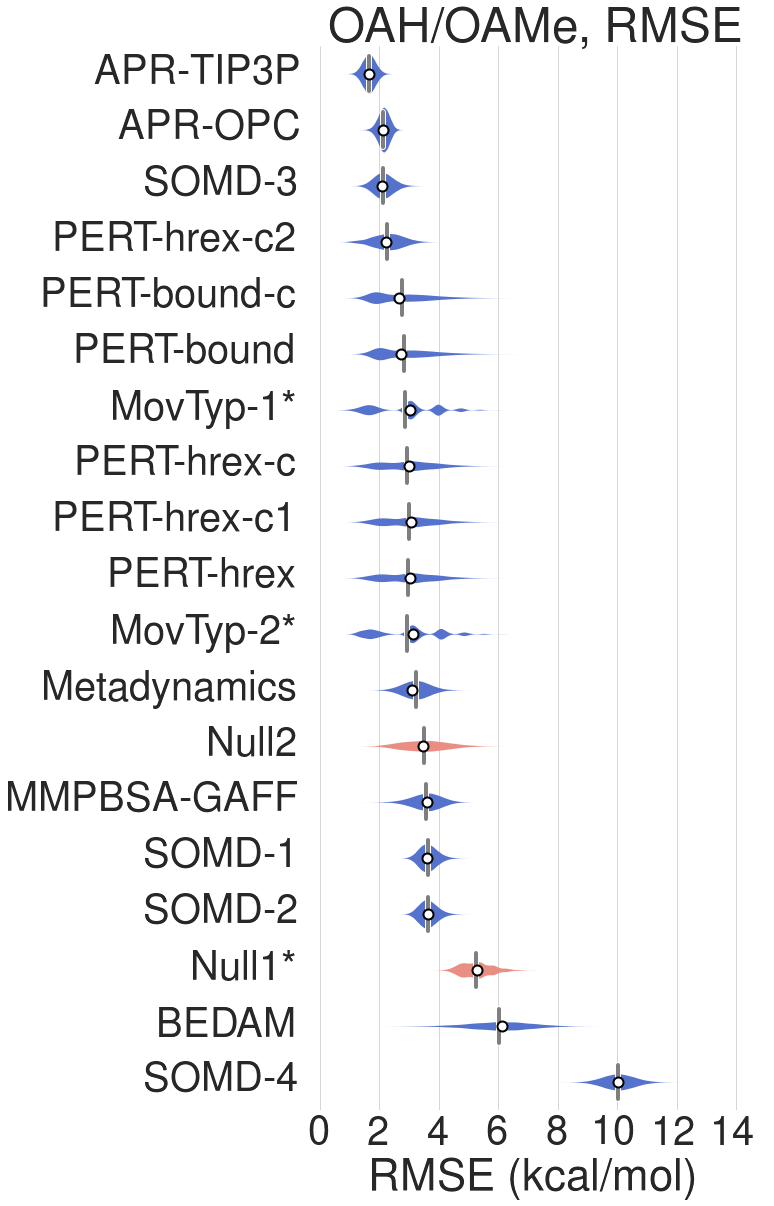

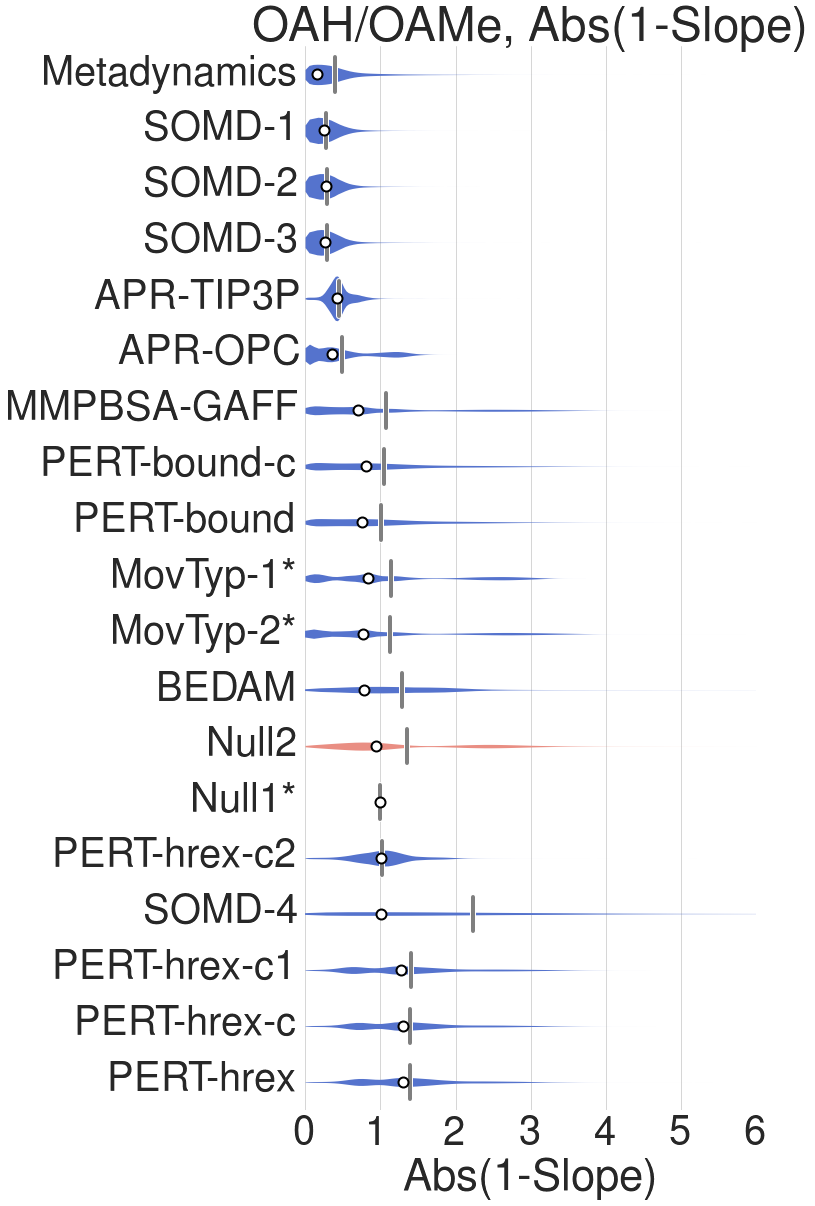

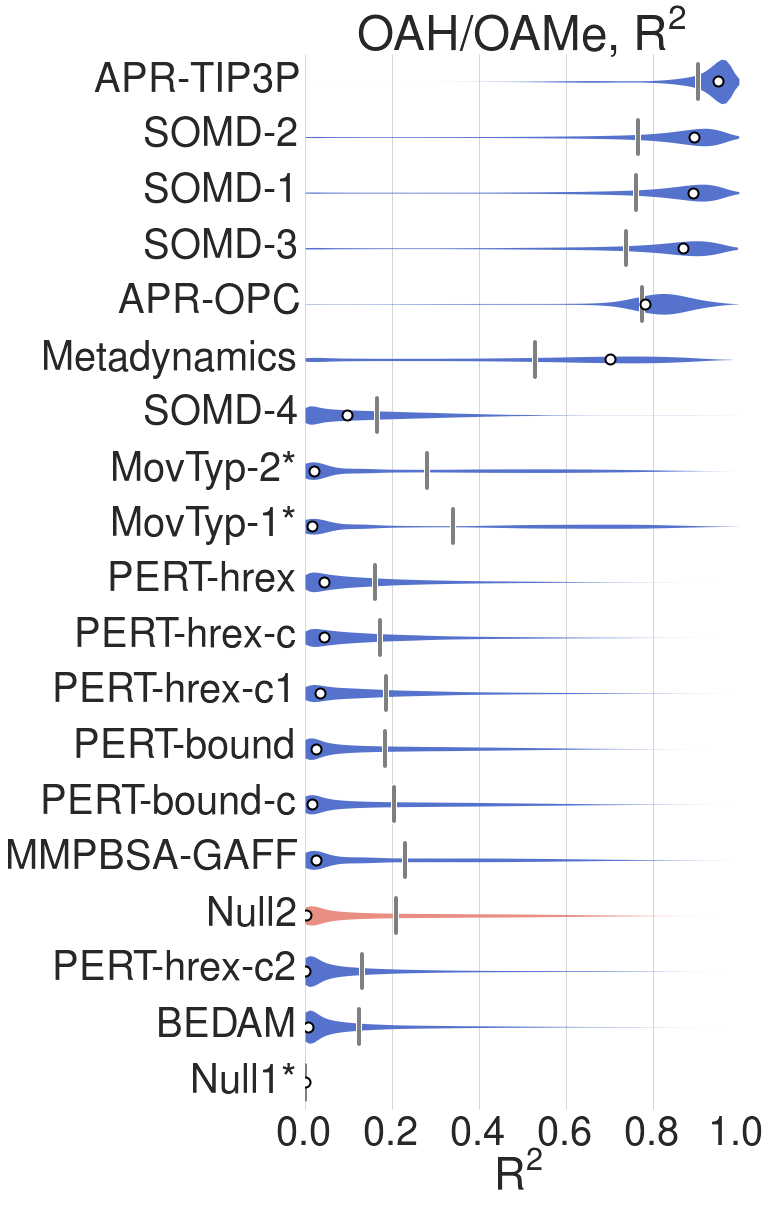

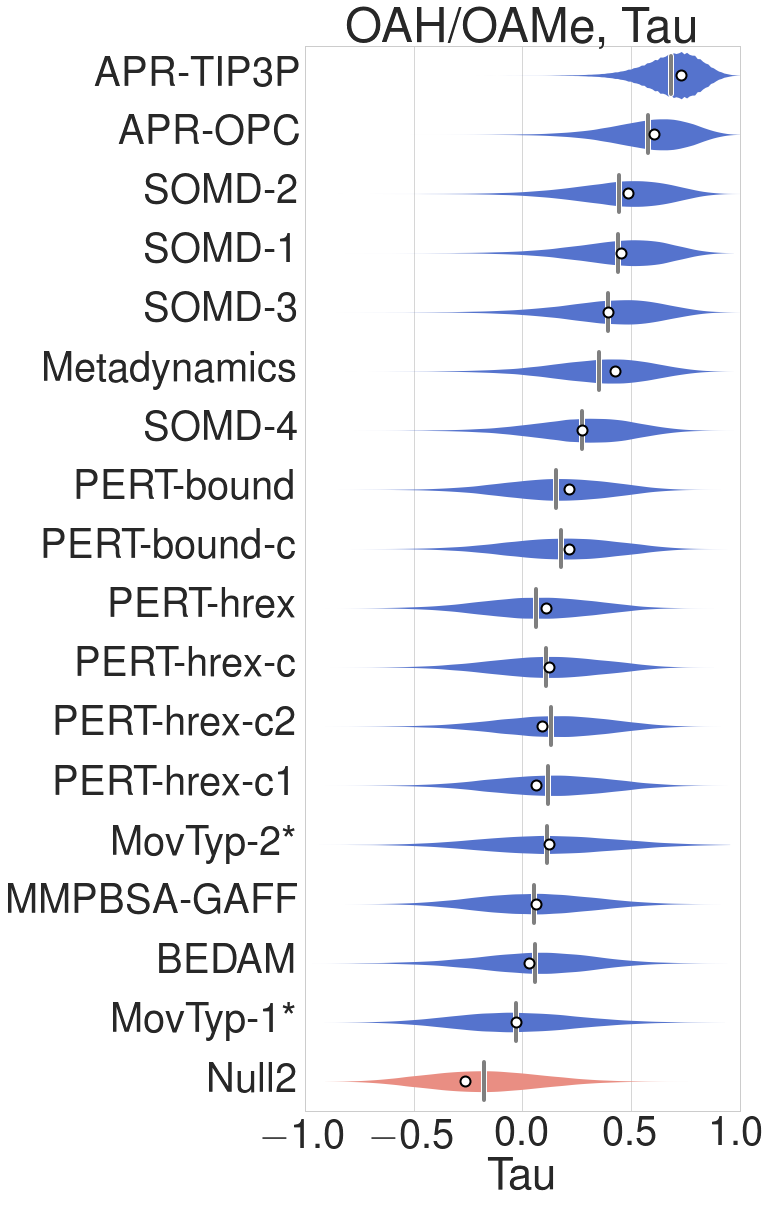

In [384]:
#SaltDep-Abs
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/SAMPL5/Boot8/Calc-OA')
string = 'ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('OAH-OAMe-absolute.pickle', 'wb'))
results = pickle.load( open('OAH-OAMe-absolute.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='OAH/OAMe', filename='OAH-OAMe-absolute')


Calculation = 4, best method index = 18, best method name = SOMD-1
[ 3 18 19 20  8  2  0 15 10 12 16 13 14 17  1 11  9  4  6  7  5 21]
Calculation = 0, best method index = 8, best method name = Metadynamics
[ 8 18 19 20  3  2 12 13  4 11 15 10  9  1  0 14 16 17 21  6  7  5]
Calculation = 3, best method index = 17, best method name = PERT-hrex
[ 4  1  9 14 16 17  0 13 15 21 10 11 12  6  5  7  8  2 20 18 19  3]
Calculation = 7, best method index = 1, best method name = Null2
[ 1 10  9  4 11 14 16 17  0 12 15  5  7 21 13  8 20  6 18 19  2  3]


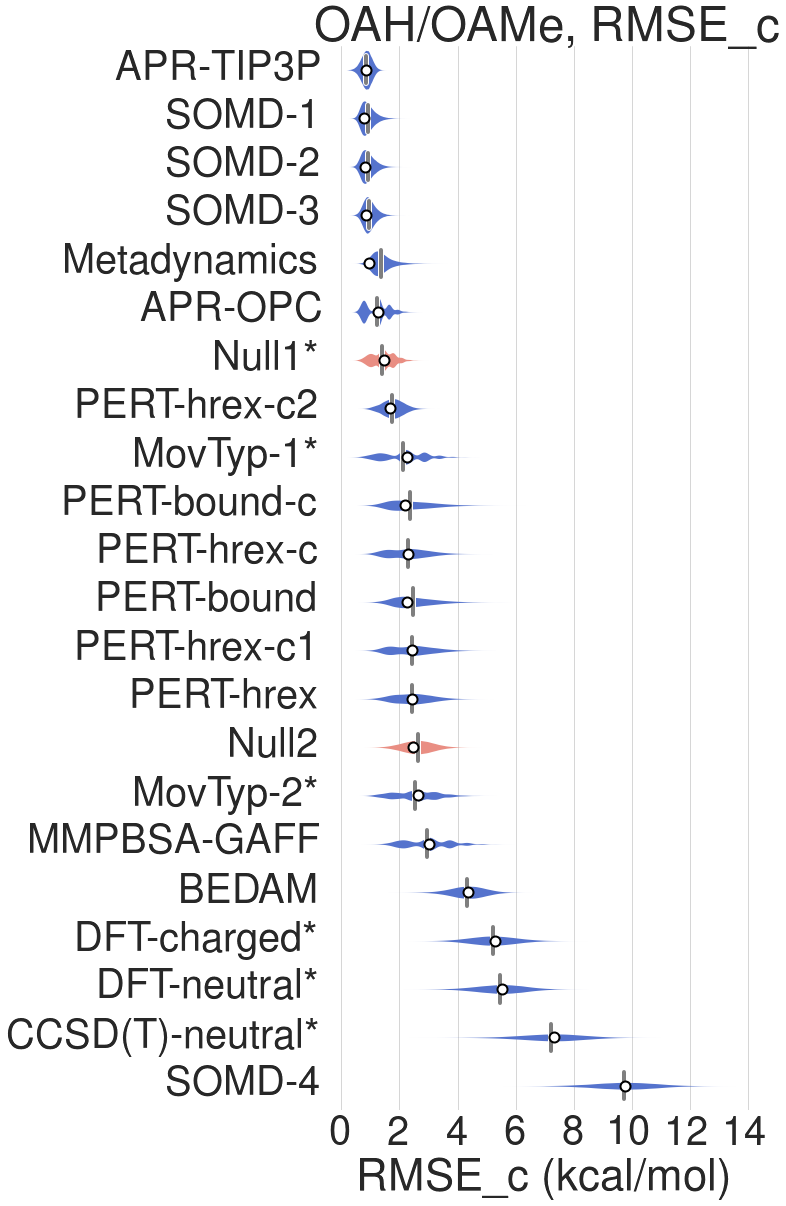

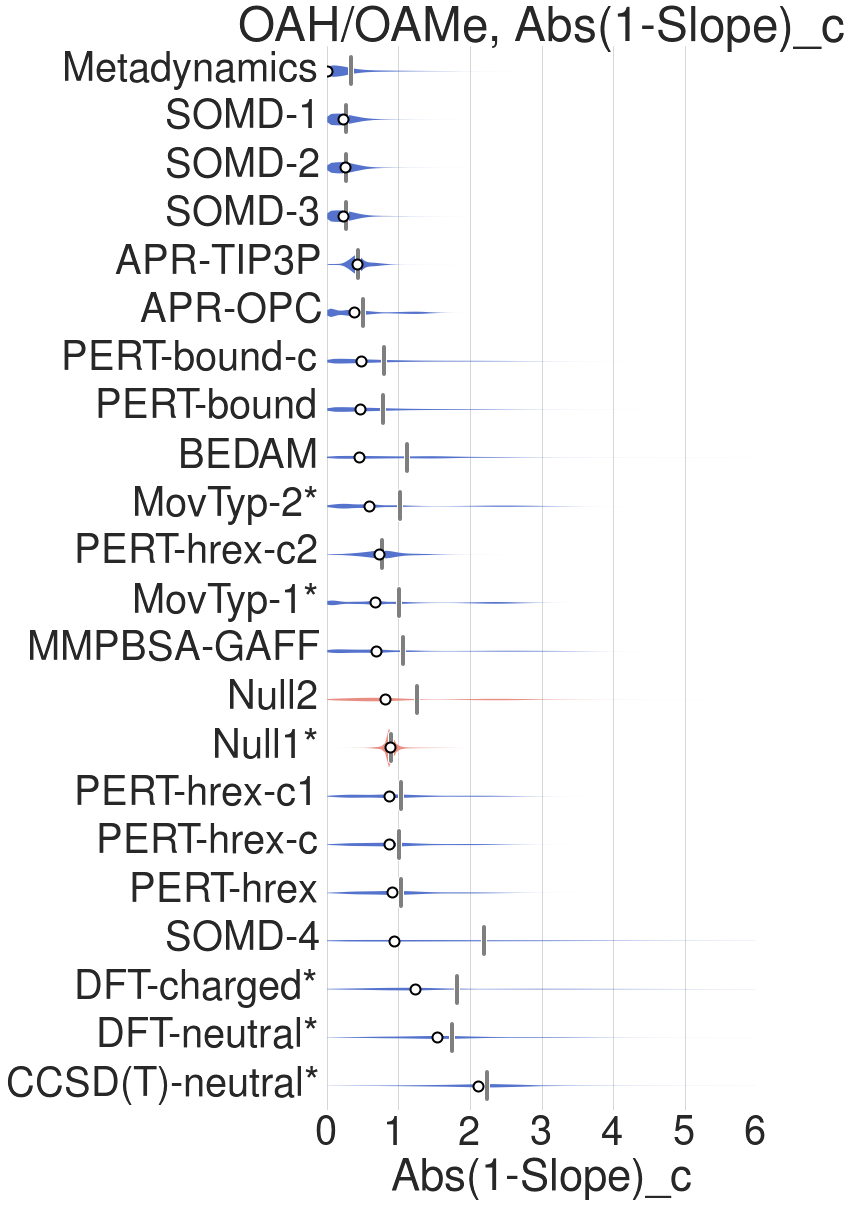

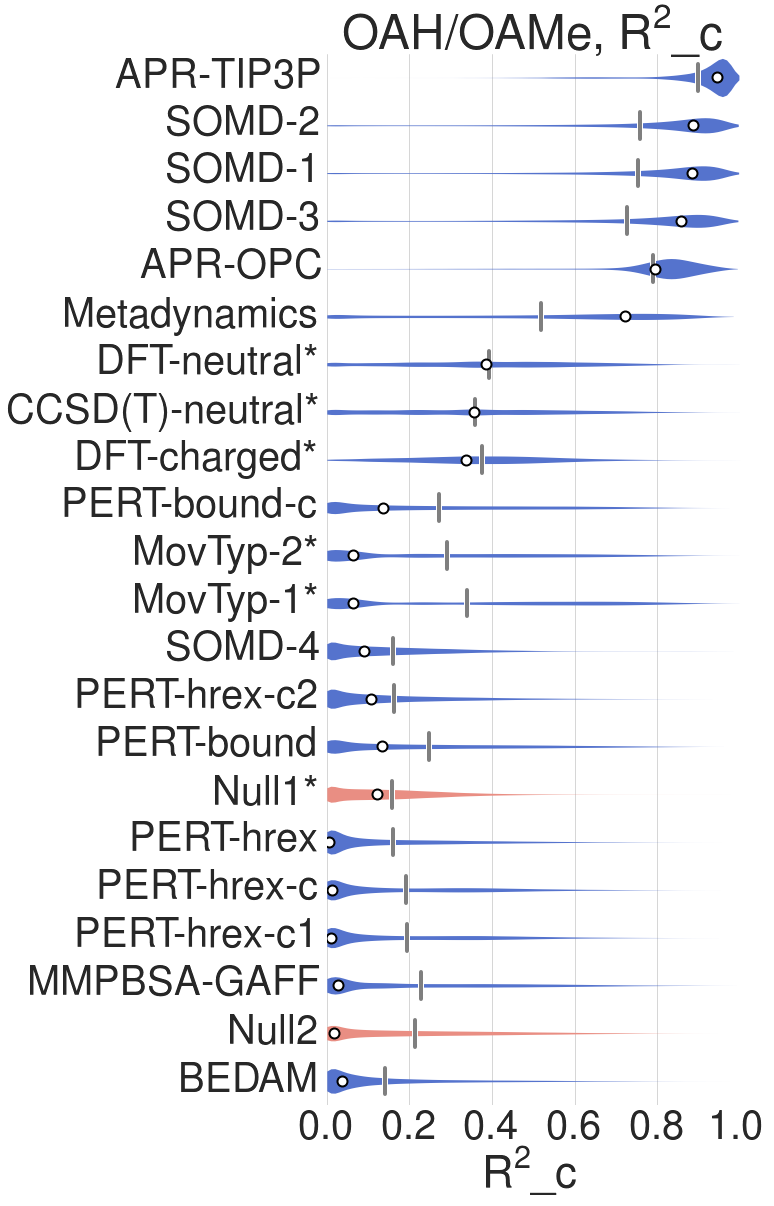

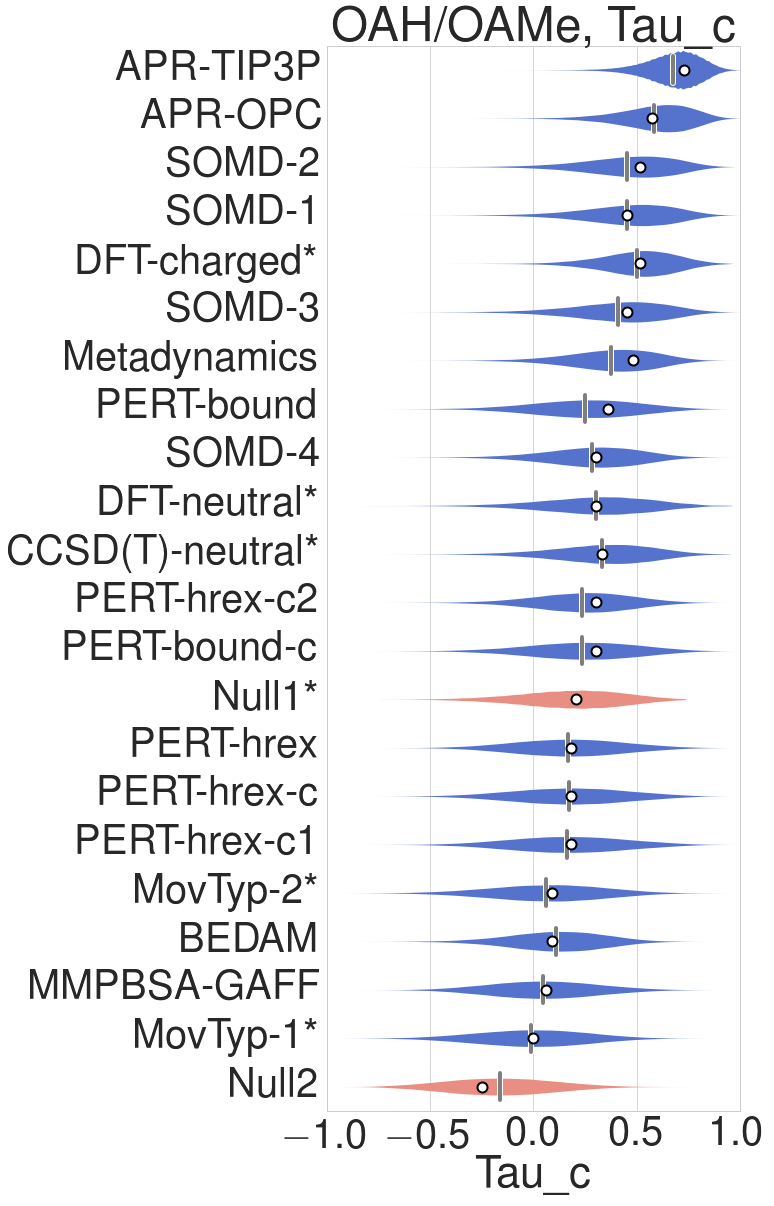

In [394]:
#SaltDep-RelCor
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/SAMPL5/Boot8/Calc-OA')
string = 'CorrectOA ka ../Exp/OASaltDep.txt Null1.txt Null2.txt APR-OPC.txt APR-TIP3P.txt BEDAM.txt CCSD(T)-neutral.txt DFT-charged.txt DFT-neutral.txt Metadynamics.txt MMPBSA-GAFF.txt MovTyp-1.txt MovTyp-2.txt PERT-bound-c.txt PERT-bound.txt PERT-hrex-c1.txt PERT-hrex-c2.txt PERT-hrex-c.txt PERT-hrex.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('OAH-OAMe-relative.pickle', 'wb'))
results = pickle.load( open('OAH-OAMe-relative.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=False, relative=True, prefix='OAH/OAMe', filename='OAH-OAMe-relative')

Calculation = 4, best method index = 1, best method name = Null2
[ 1 12  5  2 13  6  3 11  4  9  8  7  0 10]
Calculation = 0, best method index = 1, best method name = Null2
[ 1  4  0  5  6  2 12 13  3 11  7  8  9 10]
Calculation = 3, best method index = 0, best method name = Null1*
[ 0  2  5  6 12 13  3  1 11  4 10  7  8  9]
Calculation = 7, best method index = 3, best method name = BAR-dock
[ 3 11  2 12 13  5  6  1  4 10  7  8  9  0]
Removing element 0 from Order, method Null1*, from Tau calculation.


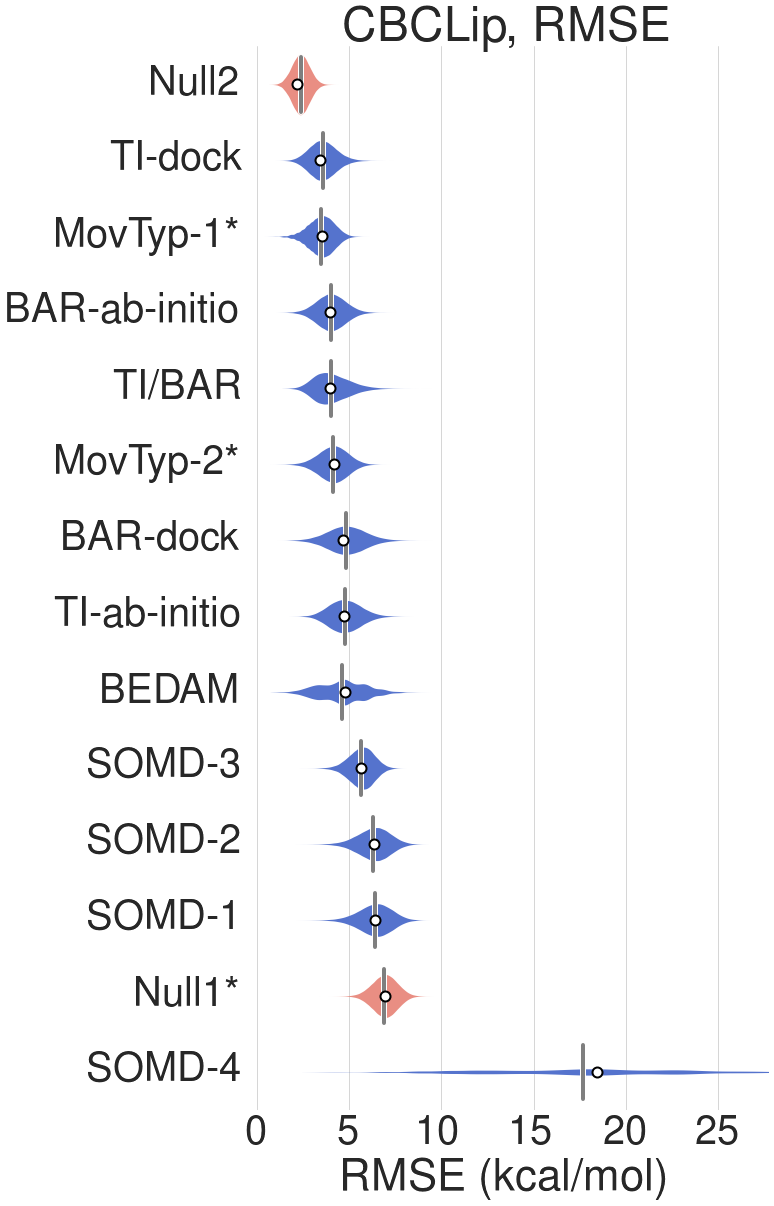

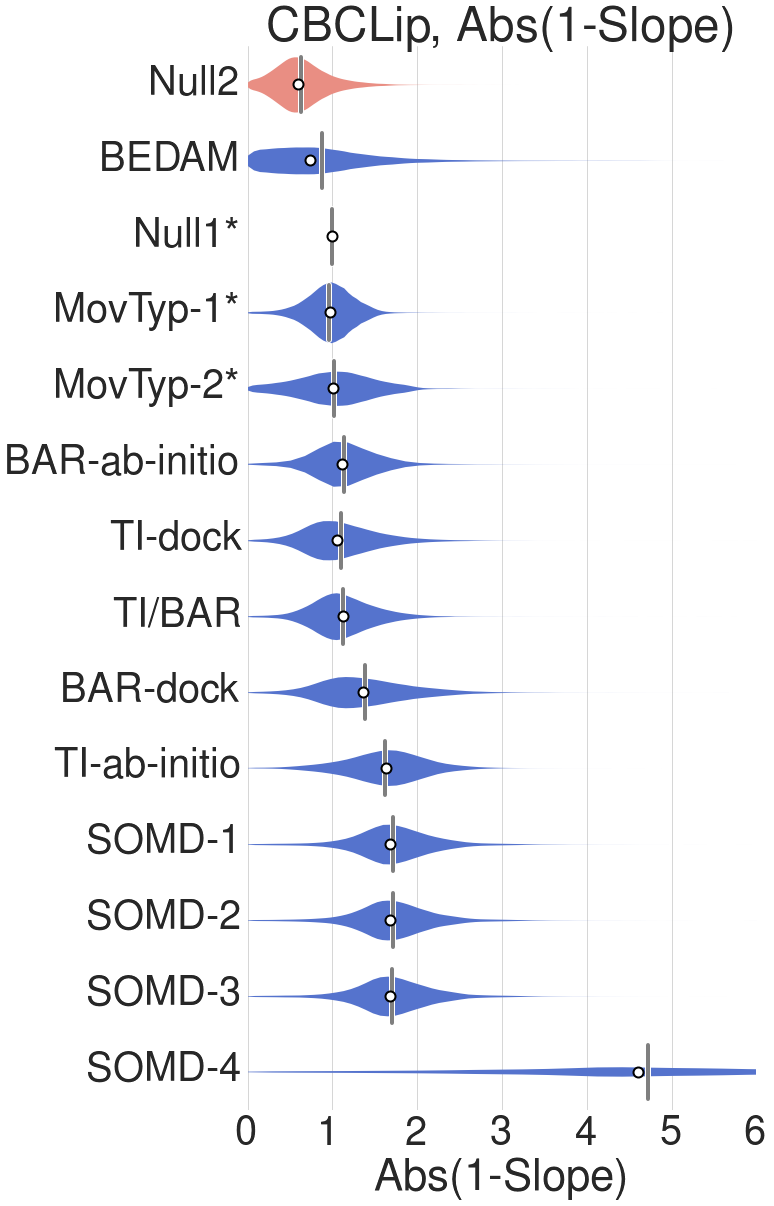

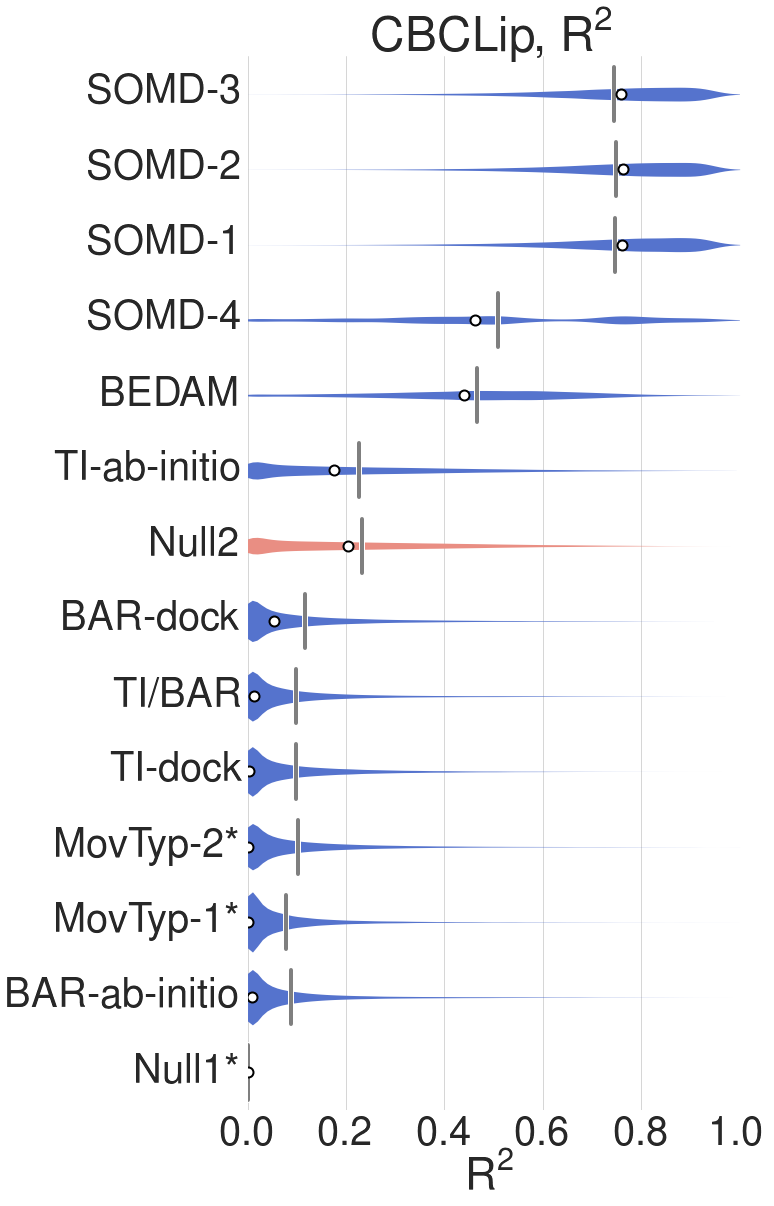

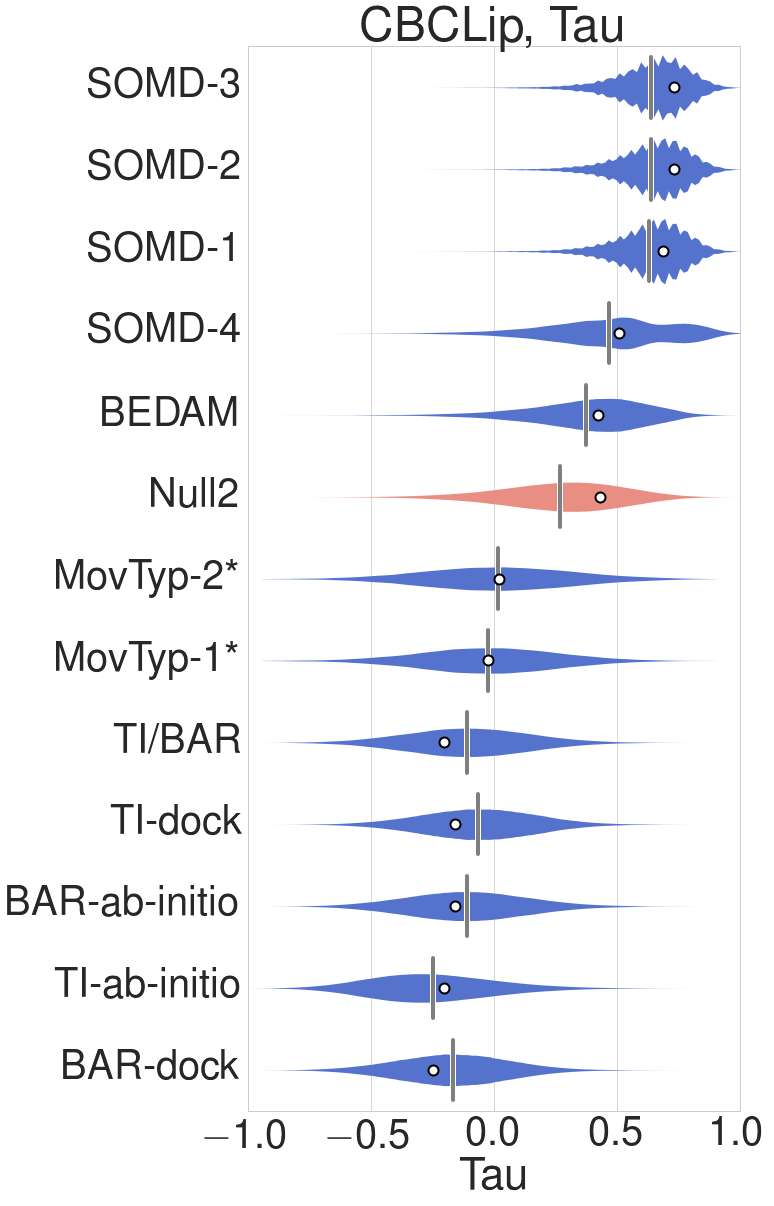

In [409]:
#CBClip-Abs
os.chdir('/run/media/dslochower/b52b33d4-b9b5-4e58-a87e-d8751720538c/2016-Research/SAMPL5/Boot8/Calc-CB')
string = 'ka ../Exp/CBClip.txt Null1.txt Null2.txt BAR-ab-initio.txt BAR-dock.txt BEDAM.txt MovTyp-1.txt MovTyp-2.txt SOMD-1.txt SOMD-2.txt SOMD-3.txt SOMD-4.txt TI-ab-initio.txt TI-dock.txt TIxBar.txt'
args = string.split()
if run_calculation:
    RawMs, AllMBoot, AllMVals, CalcNames, Nc = compute_bootstrap(args)
    results = [RawMs, AllMBoot, AllMVals, CalcNames, Nc]
    pickle.dump(results, open('CBCLip-absolute.pickle', 'wb'))
results = pickle.load( open('CBCLip-absolute.pickle', 'rb'))
RawMs, AllMBoot, AllMVals, CalcNames, Nc = results
plot_summary_horizontal_narrow(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='CBCLip', filename='CBCLip-absolute')


Calculation = 4, best method index = 1, best method name = Null2
[ 1 12  5  2 13  6  3 11  4  9  8  7  0 10]
Calculation = 0, best method index = 1, best method name = Null2
[ 1  4  0  5  6  2 12 13  3 11  7  8  9 10]
Calculation = 3, best method index = 0, best method name = Null1*
[ 0  2  5  6 12 13  3  1 11  4 10  7  8  9]
Calculation = 7, best method index = 3, best method name = BAR-dock
[ 3 11  2 12 13  5  6  1  4 10  7  8  9  0]
Removing element 0 from Order, method Null1*, from Tau calculation.


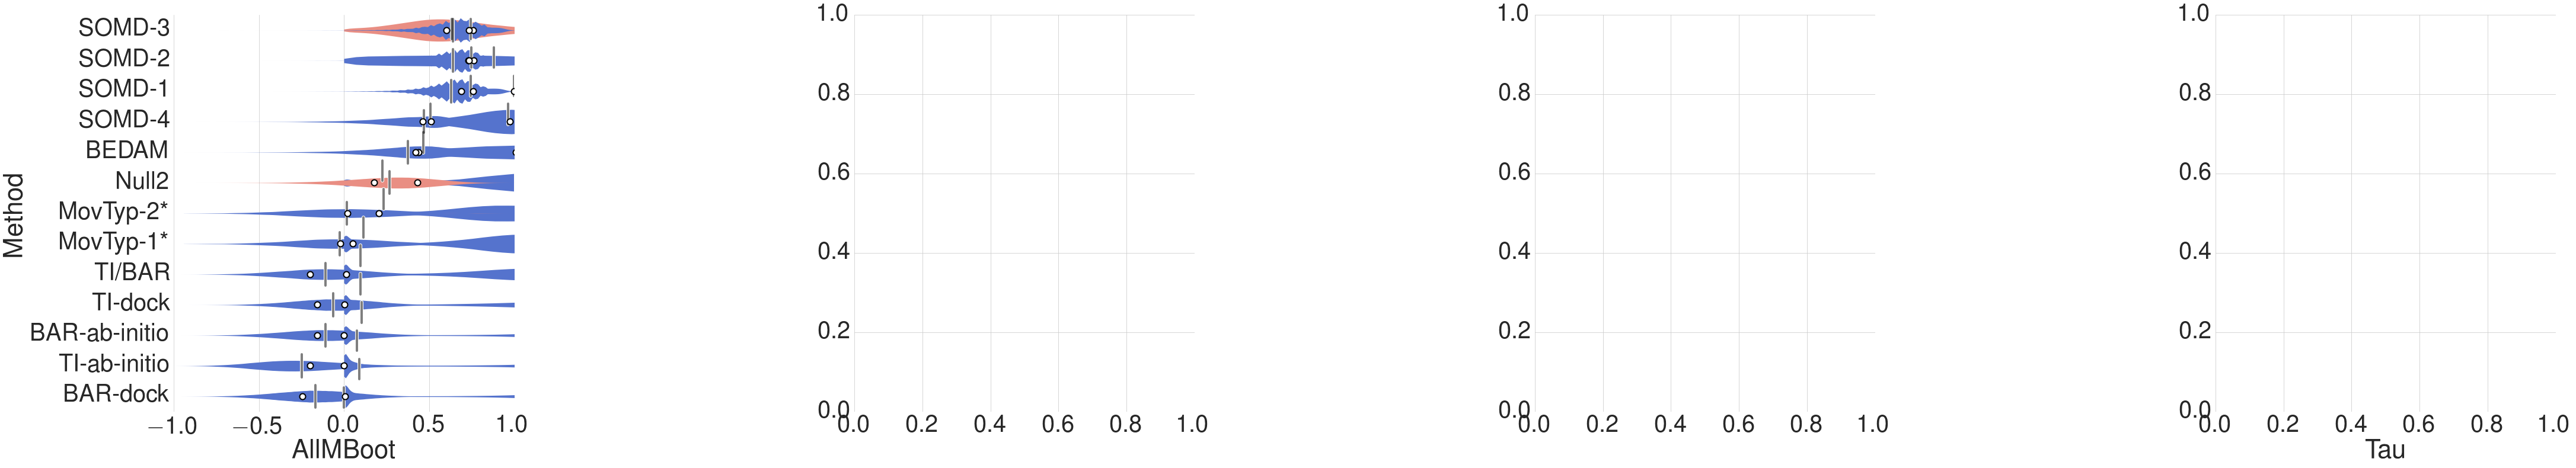

In [426]:
plot_summary_horizontal_narrow_four_in_one(Nc, RawMs, AllMBoot, AllMVals, CalcNames, absolute=True, relative=False, prefix='CBCLip', filename='CBCLip-absolute')